[Dataset de fraudes usado](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data)

**Introducción**

En este notebook se realiza un análisis de un dataset de transacciones de tarjetas de crédito con el objetivo de detectar fraudes. Se explorarán los datos, se prepararán para el modelado y se entrenarán dos clasificadores: un Perceptrón Simple (con escalado) y un modelo Adaboost. Finalmente, se realizará una optimización de hiperparámetros utilizando GridSearchCV.

In [ ]:
import kagglehub

#Utilizamos kagglehub para descargar el conjunto de datos "credit-card-fraud" de Kaggle. Se almacena la ruta local donde se guardó el archivo.

path = kagglehub.dataset_download("dhanushnarayananr/credit-card-fraud")

print("Path to dataset files:", path)

100%|██████████| 28.9M/28.9M [00:02<00:00, 12.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhanushnarayananr/credit-card-fraud/versions/1


In [ ]:
import kagglehub
import os
import pandas as pd

dataset_path = path

for filename in os.listdir(dataset_path):
  if filename.endswith(".csv"):
    file_path = os.path.join(dataset_path, filename)
    break
else:
  raise FileNotFoundError("No CSV file found in the downloaded dataset.")

data = pd.read_csv(file_path)

print("First 5 records:", data.head())


First 5 records:    distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [ ]:
data['fraud'].value_counts(normalize=True)

,proportion
fraud,
0.0,0.912597
1.0,0.087403


<ipython-input-5-1374ef07586a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraud', data=data, palette='viridis')


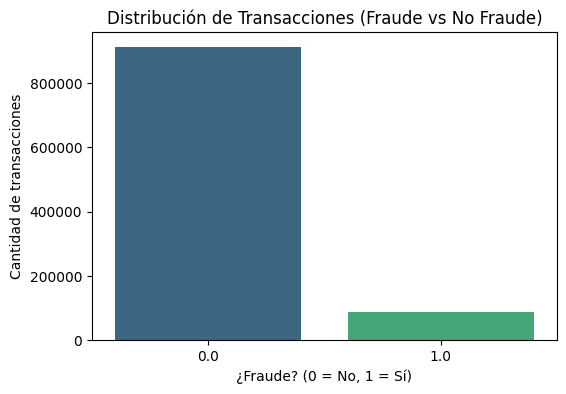

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='fraud', data=data, palette='viridis')
plt.title('Distribución de Transacciones (Fraude vs No Fraude)')
plt.xlabel('¿Fraude? (0 = No, 1 = Sí)')
plt.ylabel('Cantidad de transacciones')
plt.show()


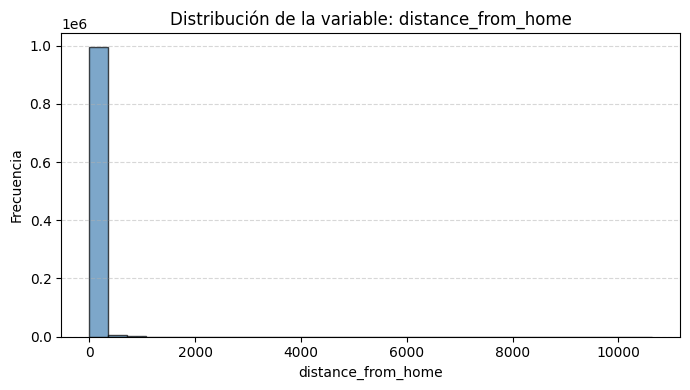

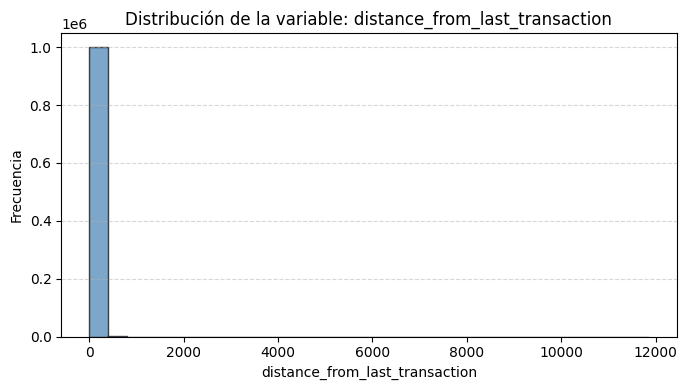

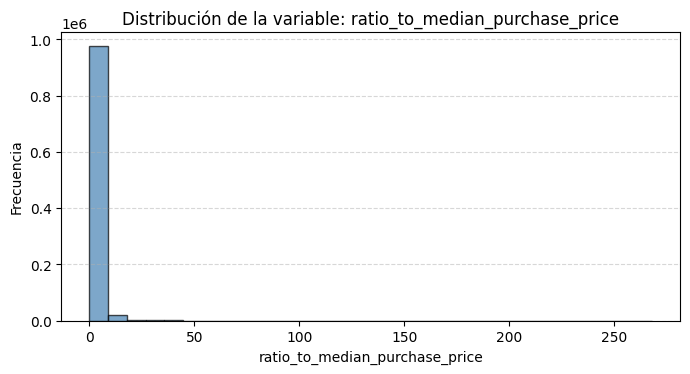

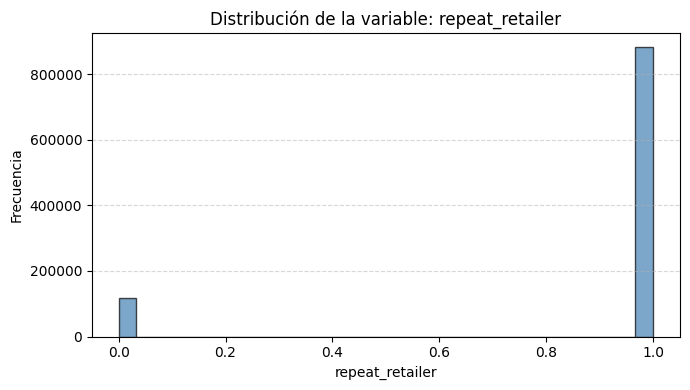

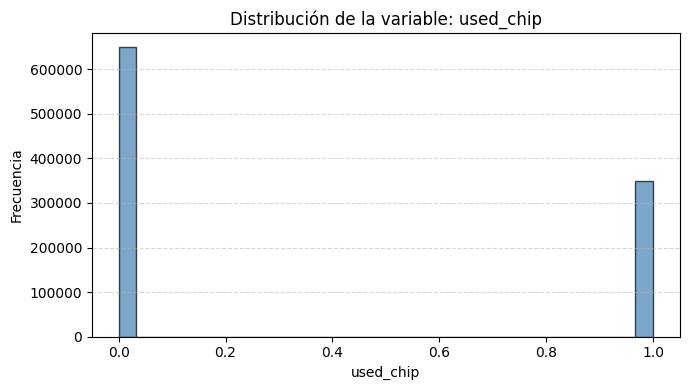

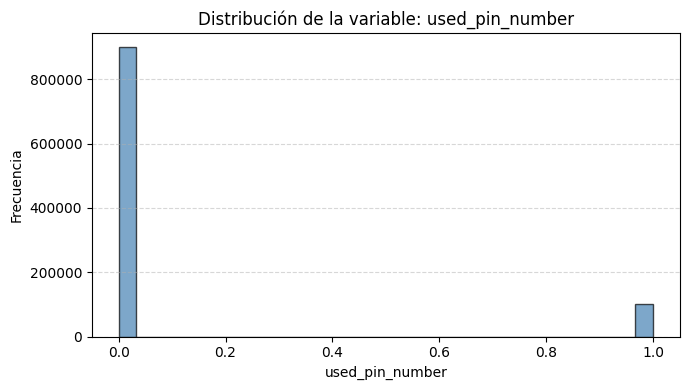

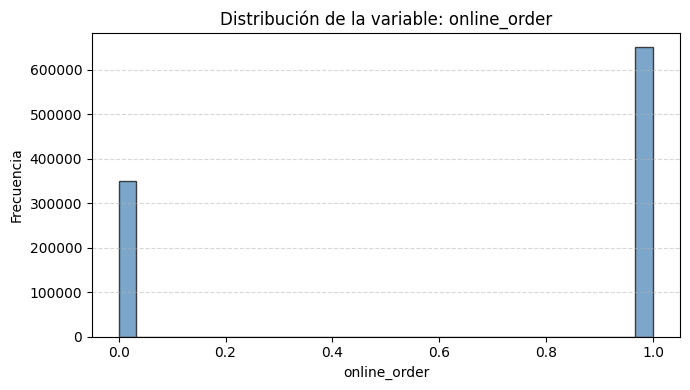

In [ ]:
import matplotlib.pyplot as plt

features = [col for col in data.columns if col != 'fraud']

for feature in features:
    plt.figure(figsize=(7, 4))
    plt.hist(data[feature], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribución de la variable: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# --- PREPARACIÓN DE DATOS ---

import pandas as pd
import numpy as np

# 1. Revisión básica
print("Dimensión del dataset:", data.shape)
print("¿Nulos por columna?\n", data.isnull().sum())
print("Duplicados en el dataset:", data.duplicated().sum())

# 2. Eliminación de duplicados (si existen)
data = data.drop_duplicates()
print("Nueva dimensión (sin duplicados):", data.shape)

# 3. Estadística descriptiva general (para justificar outliers y normalización)
display(data.describe())

Dimensión del dataset: (1000000, 8)
¿Nulos por columna?
 distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64
Duplicados en el dataset: 0
Nueva dimensión (sin duplicados): (1000000, 8)


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.model_selection import train_test_split

# Definición de X (features) e y (target)
X = data.drop(columns=['fraud'])
y = data['fraud']

# División para todos los modelos (misma semilla y estratificación para comparar resultados)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------------
# 1. Perceptrón Simple (requiere escalado)
X_train_perc = X_train_full.copy()
X_test_perc = X_test_full.copy()
y_train_perc = y_train_full.copy()
y_test_perc = y_test_full.copy()

# 2. Adaboost (no requiere escalado)
X_train_ada = X_train_full.copy()
X_test_ada = X_test_full.copy()
y_train_ada = y_train_full.copy()
y_test_ada = y_test_full.copy()

# 3. Modelos con Hiperparámetros (puede ser Adaboost optimizado, Random Forest, etc.)
X_train_hp = X_train_full.copy()
X_test_hp = X_test_full.copy()
y_train_hp = y_train_full.copy()
y_test_hp = y_test_full.copy()

# Verificación de tamaños
print("Perceptrón Simple:", X_train_perc.shape, X_test_perc.shape)
print("Adaboost:", X_train_ada.shape, X_test_ada.shape)
print("Hiperparámetros:", X_train_hp.shape, X_test_hp.shape)


Perceptrón Simple: (700000, 7) (300000, 7)
Adaboost: (700000, 7) (300000, 7)
Hiperparámetros: (700000, 7) (300000, 7)


DATOS PREPARADOS

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Escalado para Perceptrón
scaler_perc = StandardScaler()
X_train_perc_scaled = scaler_perc.fit_transform(X_train_perc)
X_test_perc_scaled = scaler_perc.transform(X_test_perc)

# Definición y entrenamiento
perc = Perceptron(max_iter=300, random_state=42)
perc.fit(X_train_perc_scaled, y_train_perc)

# Predicción y evaluación
y_pred_perc = perc.predict(X_test_perc_scaled)

print("=== Perceptrón Simple ===")
print(f"Exactitud: {accuracy_score(y_test_perc, y_pred_perc):.4f}")
print(f"Precisión: {precision_score(y_test_perc, y_pred_perc):.4f}")
print(f"Sensibilidad: {recall_score(y_test_perc, y_pred_perc):.4f}")
print(f"F1 Score: {f1_score(y_test_perc, y_pred_perc):.4f}")
print("\nReporte de Clasificación completo:\n")
print(classification_report(y_test_perc, y_pred_perc, digits=4))
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_perc, y_pred_perc))


=== Perceptrón Simple ===
Exactitud: 0.9316
Precisión: 0.5997
Sensibilidad: 0.6525
F1 Score: 0.6250

Reporte de Clasificación completo:

              precision    recall  f1-score   support

         0.0     0.9664    0.9583    0.9623    273779
         1.0     0.5997    0.6525    0.6250     26221

    accuracy                         0.9316    300000
   macro avg     0.7831    0.8054    0.7937    300000
weighted avg     0.9344    0.9316    0.9329    300000

Matriz de Confusión:

[[262360  11419]
 [  9112  17109]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Definición y entrenamiento
adaboost = AdaBoostClassifier(
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
adaboost.fit(X_train_ada, y_train_ada)

# Predicción y evaluación
y_pred_ada = adaboost.predict(X_test_ada)

print("=== Adaboost ===")
print(f"Exactitud: {accuracy_score(y_test_ada, y_pred_ada):.4f}")
print(f"Precisión: {precision_score(y_test_ada, y_pred_ada):.4f}")
print(f"Sensibilidad: {recall_score(y_test_ada, y_pred_ada):.4f}")
print(f"F1 Score: {f1_score(y_test_ada, y_pred_ada):.4f}")
print("\nReporte de Clasificación completo:\n")
print(classification_report(y_test_ada, y_pred_ada, digits=4))
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_ada, y_pred_ada))


=== Adaboost ===
Exactitud: 0.9973
Precisión: 0.9977
Sensibilidad: 0.9715
F1 Score: 0.9844

Reporte de Clasificación completo:

              precision    recall  f1-score   support

         0.0     0.9973    0.9998    0.9985    273779
         1.0     0.9977    0.9715    0.9844     26221

    accuracy                         0.9973    300000
   macro avg     0.9975    0.9856    0.9915    300000
weighted avg     0.9973    0.9973    0.9973    300000

Matriz de Confusión:

[[273720     59]
 [   747  25474]]


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0, 2.0]
}

adaboost_hp = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=adaboost_hp,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_hp, y_train_hp)

best_ada = grid_search.best_estimator_
y_pred_hp = best_ada.predict(X_test_hp)

print("=== Adaboost Optimizado (GridSearchCV) ===")
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Exactitud: {accuracy_score(y_test_hp, y_pred_hp):.4f}")
print(f"Precisión: {precision_score(y_test_hp, y_pred_hp):.4f}")
print(f"Sensibilidad: {recall_score(y_test_hp, y_pred_hp):.4f}")
print(f"F1 Score: {f1_score(y_test_hp, y_pred_hp):.4f}")
print("\nReporte de Clasificación completo:\n")
print(classification_report(y_test_hp, y_pred_hp, digits=4))
print("Matriz de Confusión:\n")
print(confusion_matrix(y_test_hp, y_pred_hp))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
=== Adaboost Optimizado (GridSearchCV) ===
Mejores hiperparámetros: {'learning_rate': 1.0, 'n_estimators': 200}
Exactitud: 0.9999
Precisión: 1.0000
Sensibilidad: 0.9989
F1 Score: 0.9995

Reporte de Clasificación completo:

              precision    recall  f1-score   support

         0.0     0.9999    1.0000    0.9999    273779
         1.0     1.0000    0.9989    0.9995     26221

    accuracy                         0.9999    300000
   macro avg     0.9999    0.9995    0.9997    300000
weighted avg     0.9999    0.9999    0.9999    300000

Matriz de Confusión:

[[273779      0]
 [    28  26193]]
